<h1 style="color:red; font-weight:bold;">
Dự đoán Các Chỉ Số Ảnh Hưởng Đến Chất Lượng Không Khí tại TP.HCM 
</h1>


<h2 style="color:Yellow; font-weight:bold;">
Dự án dự đoán nồng độ PM2.5 tại TP.HCM bằng mô hình học máy kết hợp giữa XGBoost và RandomForest.<br>
Nhằm cung cấp thông tin kịp thời cho người dân và cơ quan chức năng.  
</h2>

<h3 style="color:White; font-weight:bold;">
Thư Viện
</h3>

In [49]:
#Tải thư viện statsmodels 
! pip install statsmodels


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [50]:
import os
import pickle
from math import sqrt

## Data wrangling and loader
import pandas as pd
import numpy as np

## Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## Data preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Testing for stationarity of forecast variable
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

## xgboost - only using as requested
import xgboost as xgb


## Suppressing unnecessary warnings
import warnings
warnings.filterwarnings("ignore")


<h3 style="color:White; font-weight:bold;">
Thiết lập thư mục làm việc hiện tại thành thư mục dự án
</h3>

In [51]:
# File paths
BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, "Data")
CLEANED_DATASET_PATH = os.path.join(BASE_DIR, "cleaned_datasets")
DATASET_PATH = os.path.join(DATA_DIR, "DATASET_state_weather_aqi_data_PPNC.csv")

In [52]:
# Creating appropriate folders if not already existing
if not os.path.exists(CLEANED_DATASET_PATH):
    os.makedirs(CLEANED_DATASET_PATH)

<h3 style="color:White; font-weight:bold;">
Tải DATA lên 
</h3>

In [53]:
# Default plotting configurations
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 18

In [54]:
# Import air quality data
aqi_data = pd.read_csv(DATASET_PATH)

# View data shape and basic information
print("Dataset shape:", aqi_data.shape, "\n")
print("Dataset information:\n")

Dataset shape: (1564, 18) 

Dataset information:



In [55]:
aqi_data.info()
print("\nColumn names:", list(aqi_data.columns), "\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1564 entries, 0 to 1563
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   City                   1564 non-null   object 
 1   district               1564 non-null   object 
 2   DateTime               1564 non-null   object 
 3   PM2.5                  1391 non-null   float64
 4   PM10                   1227 non-null   float64
 5   NO2                    1409 non-null   float64
 6   NH3                    1120 non-null   float64
 7   SO2                    1351 non-null   float64
 8   CO                     1501 non-null   float64
 9   OZONE                  1415 non-null   float64
 10  AQI                    1564 non-null   int64  
 11  TEMP                   1564 non-null   float64
 12  PRES                   1564 non-null   float64
 13  DEWP                   1564 non-null   float64
 14  RAIN                   1564 non-null   float64
 15  wd  

In [56]:
# View data description
print("Dataset statistics:\n")
print(aqi_data.describe())

Dataset statistics:

             PM2.5         PM10          NO2          NH3          SO2  \
count  1391.000000  1227.000000  1409.000000  1120.000000  1351.000000   
mean    182.887132   141.654442    46.735273     8.410714    16.469282   
std     106.309536    66.750720    31.698556     5.592273    12.578891   
min       9.000000    21.000000     1.000000     1.000000     1.000000   
25%      88.000000    93.000000    24.000000     4.000000     8.000000   
50%     164.000000   130.000000    42.000000     7.000000    13.000000   
75%     278.500000   184.500000    64.000000    12.000000    20.000000   
max     441.000000   394.000000   247.000000    34.000000    92.000000   

                CO        OZONE          AQI         TEMP         PRES  \
count  1501.000000  1415.000000  1564.000000  1564.000000  1564.000000   
mean     51.441706    29.792933   188.368286    29.086445  1007.708312   
std      28.032483    22.786605    98.940549     2.978614     2.582796   
min       1.0000

In [57]:
# Check for missing values
print("\nMissing values per column:\n")
print(aqi_data.isna().sum())


Missing values per column:

City                       0
district                   0
DateTime                   0
PM2.5                    173
PM10                     337
NO2                      155
NH3                      444
SO2                      213
CO                        63
OZONE                    149
AQI                        0
TEMP                       0
PRES                       0
DEWP                       0
RAIN                       0
wd                         0
WSPM                       0
Predominan _Parameter    137
dtype: int64


<h3 style="color:White; font-weight:bold;">
Xử lý dữ liệu thiếu
</h3>

In [58]:
# Chuyển cột `DateTime` sang kiểu thời gian và đặt làm chỉ mục.
aqi_data["DateTime"] = pd.to_datetime(aqi_data["DateTime"], format="%m/%d/%Y %H:%M")
aqi_data.set_index("DateTime", inplace=True)

# Giữ bản sao dữ liệu gốc để so sánh.
original_data = aqi_data.copy()
# Xử lý các giá trị bị thiếu bằng cách nội suy thay vì loại bỏ
clean_aqi_data = aqi_data.copy()

# Dùng interpolation numerical để xử lý giá trị thiếu cho các cột số.
numerical_cols = ['PM2.5', 'PM10', 'NO2', 'NH3', 'SO2', 'CO', 'OZONE', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']
for col in numerical_cols:
    if col in clean_aqi_data.columns:
        # Sử dụng nội suy theo thời gian cho dữ liệu chuỗi thời gian
        clean_aqi_data[col] = clean_aqi_data[col].interpolate(method='time', limit_direction='both')
        # Điền bất kỳ NaN còn lại nào bằng cách điền tiến/lùi
        clean_aqi_data[col] = clean_aqi_data[col].fillna(method='ffill').fillna(method='bfill')

# Với cột phân loại `Predominan_Parameter`, dùng phương pháp điền tiến (forward fill) và lùi (backward fill).
if 'Predominan_Parameter' in clean_aqi_data.columns:
    clean_aqi_data['Predominan_Parameter'] = clean_aqi_data['Predominan_Parameter'].fillna(method='ffill').fillna(method='bfill')

# In ra số lượng giá trị thiếu sau khi xử lý.
print("\nMissing values per column after interpolation:\n")
print(clean_aqi_data.isna().sum())
print("\nClean dataset shape:", clean_aqi_data.shape, "\n")


Missing values per column after interpolation:

City                       0
district                   0
PM2.5                      0
PM10                       0
NO2                        0
NH3                        0
SO2                        0
CO                         0
OZONE                      0
AQI                        0
TEMP                       0
PRES                       0
DEWP                       0
RAIN                       0
wd                         0
WSPM                       0
Predominan _Parameter    137
dtype: int64

Clean dataset shape: (1564, 17) 



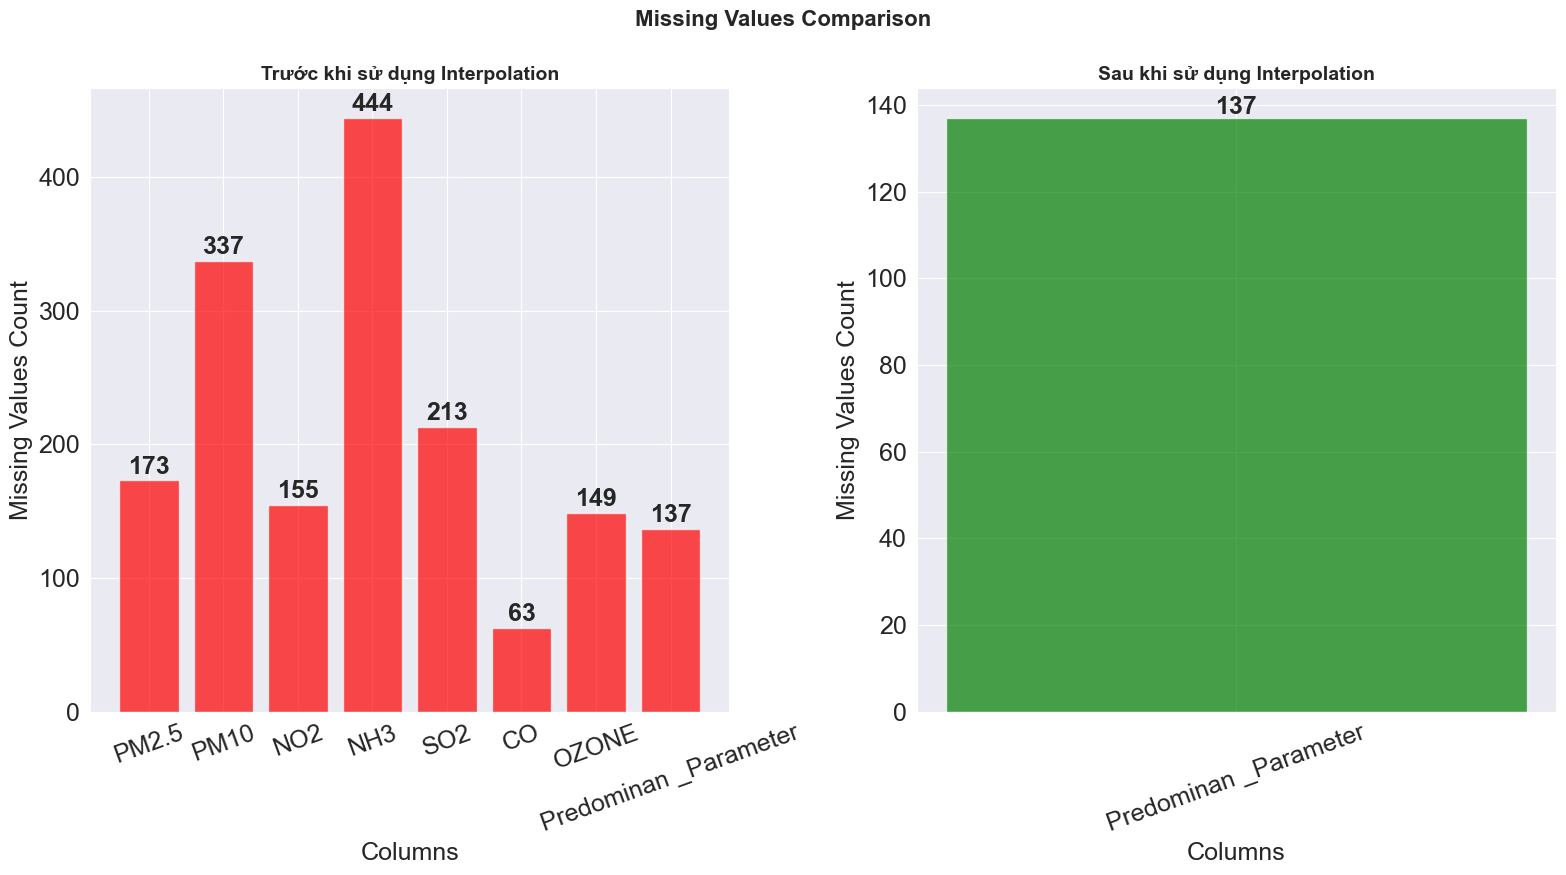

In [59]:
# Missing values comparison chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
# Trước khi xử dụng interpolation
missing_before = original_data.isna().sum()
missing_before = missing_before[missing_before > 0]
ax1.bar(range(len(missing_before)), missing_before.values, color='red', alpha=0.7)
ax1.set_title('Trước khi sử dụng Interpolation', fontsize=14, fontweight='bold')
ax1.set_xlabel('Columns')
ax1.set_ylabel('Missing Values Count')
ax1.set_xticks(range(len(missing_before)))
ax1.set_xticklabels(missing_before.index, rotation=20)
for i, v in enumerate(missing_before.values):
    ax1.text(i, v + 5, str(v), ha='center', fontweight='bold')
# Sau khi xử dụng interpolation
missing_after = clean_aqi_data.isna().sum()
missing_after = missing_after[missing_after > 0] if missing_after.sum() > 0 else pd.Series([0], index=['Complete'])
ax2.bar(range(len(missing_after)), missing_after.values, color='green', alpha=0.7)
ax2.set_title('Sau khi sử dụng Interpolation', fontsize=14, fontweight='bold')
ax2.set_xlabel('Columns')
ax2.set_ylabel('Missing Values Count')
ax2.set_xticks(range(len(missing_after)))
ax2.set_xticklabels(missing_after.index, rotation=20)
for i, v in enumerate(missing_after.values):
    ax2.text(i, v + 1, str(v), ha='center', fontweight='bold')

plt.suptitle('Missing Values Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(CLEANED_DATASET_PATH, 'missing_values_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

In [60]:
# Save the cleaned dataset
clean_aqi_data.to_csv(os.path.join(CLEANED_DATASET_PATH, 'clean_aqi_data.csv'), index=True)

In [61]:
# 1. View first and last few records
print("First 5 records:")
clean_aqi_data.head()

First 5 records:


,City,district,PM2.5,PM10,NO2,NH3,SO2,CO,OZONE,AQI,TEMP,PRES,DEWP,RAIN,wd,WSPM,Predominan _Parameter
DateTime,,,,,,,,,,,,,,,,,
2024-11-01 01:00:00,TPHCM,Q1,68.0,64.0,17.0,4.0,28.0,31.0,40.0,68,30.0,1009.0,22.0,0.0,130.0,13.0,PM2.5
2024-11-01 02:00:00,TPHCM,Q3,67.0,70.0,23.0,2.0,13.0,49.0,77.0,77,29.0,1009.0,23.1,0.0,149.0,12.8,OZONE
2024-11-01 03:00:00,TPHCM,Q7,32.0,81.5,26.0,5.0,6.0,19.0,16.0,32,29.0,1008.0,23.0,0.0,150.0,13.0,PM2.5
2024-11-01 04:00:00,TPHCM,Tân Bình,93.0,93.0,31.0,3.0,9.0,57.0,61.0,93,29.0,1008.0,23.0,0.0,130.0,16.6,PM10
2024-11-01 05:00:00,TPHCM,Tân Phú,60.0,55.0,20.0,5.0,18.0,29.0,53.0,60,28.9,1008.1,23.2,0.0,140.0,16.4,PM2.5


In [62]:
# 1. View records
print("\nLast 5 records:")
clean_aqi_data.tail()


Last 5 records:


,City,district,PM2.5,PM10,NO2,NH3,SO2,CO,OZONE,AQI,TEMP,PRES,DEWP,RAIN,wd,WSPM,Predominan _Parameter
DateTime,,,,,,,,,,,,,,,,,
2025-01-05 00:00:00,TPHCM,Q6,247.0,167.0,67.0,5.0,12.0,43.0,55.0,247,23.1,1012.0,16.1,0.0,50.0,7.6,PM2.5
2025-01-05 01:00:00,TPHCM,Q9,163.0,142.0,57.0,7.0,10.0,39.0,8.0,163,22.1,1012.0,16.1,0.0,20.0,5.4,PM2.5
2025-01-05 02:00:00,TPHCM,Bình Tân,279.0,215.0,78.0,11.0,23.0,31.0,53.0,279,26.1,1010.0,23.1,0.1,120.0,11.2,PM2.5
2025-01-05 03:00:00,TPHCM,Q1,162.0,136.0,43.0,4.0,16.0,34.0,44.0,162,21.1,1011.0,17.1,0.0,340.0,5.4,PM2.5
2025-01-05 04:00:00,TPHCM,Q4,213.0,152.0,55.0,5.0,11.0,95.0,64.0,213,22.1,1010.0,17.1,0.0,348.6,3.6,PM2.5


<h2 style="color:Yellow; font-weight:bold;">
Tiến hành áp dụng thuật toán
</h2>

In [63]:
#Các chỉ số đánh giá: MAE, MSE, RMSE, R-Squared
METRICS = ['MAE', 'MSE', 'RMSE', 'R-Squared'] 

In [64]:
def evaluate_model_performance(y_true, predictions, label='dt'):
    mae = mean_absolute_error(y_true, predictions)
    mse = mean_squared_error(y_true, predictions)
    rmse = sqrt(mean_squared_error(y_true, predictions))
    r2 = r2_score(y_true, predictions)

    results = {label: [mae, mse, rmse, r2]}
    
    return pd.DataFrame(results, index=METRICS).round(3)

<h3 style="color:White; font-weight:bold;">
Hàm Chức Năng
</h3>

In [65]:
def visualize_features_series(df,  hours=24*31*6, index=-1):
    colors = ['black', 'red', 'blue', 'green', 'gray', 'orange']
    sub_df = df[['TEMP','PRES','DEWP','RAIN','wd','WSPM']]
    
    if index < 0 and hours <= len(sub_df):   # if index is negative, select last 'hours' series
        sub_df = sub_df.iloc[-hours:]
    elif index > 0 and hours <= len(sub_df): # otherwise, select first 'hours' series data
        sub_df = sub_df.iloc[:-hours]

    plt.figure(figsize=(16, 8), dpi=150)
    fig, ax = plt.subplots(len(sub_df.columns), sharex=True)

    for i, col in enumerate(sub_df):
        ax[i].plot(sub_df[col], label=col, color=colors[i])
        ax[i].set_title(col)
    fig.tight_layout()


def visualize_pollutants_series(df, hours=24*31*6, index=-1):
    colors = ['black', 'red', 'blue', 'green', 'gray', 'orange']
    sub_df = df.iloc[:, -6:]

    if index < 0 and hours <= len(sub_df):   # if index is negative, select last 'hours' series
        sub_df = sub_df.iloc[-hours:]
    elif index > 0 and hours <= len(sub_df): # otherwise, select first 'hours' series data
        sub_df = sub_df.iloc[:-hours]

    plt.figure(figsize=(16, 8), dpi=150)
    fig, ax = plt.subplots(len(sub_df.columns), sharex=True)

    for i, col in enumerate(sub_df):
        ax[i].plot(sub_df[col], label=col, color=colors[i])
        ax[i].set_title(col)
    fig.tight_layout()

In [66]:
# from statsmodels.tsa.stattools import adfuller
def test_for_stationarity_single(series_data=None):
    results = adfuller(series_data.dropna())
    print(f'p-value: {results[1]}')    
    if results[1] < 0.05:  # if p value is less than 0.05, it is assumed to be stationary
        print('Series is stationary')
    else:
        print('Series is not stationary')


def plot_corr(corr, title='Feature Correlations'):
    # Tạo mask mới chỉ che phần trùng lặp phía trên đường chéo
    mask = np.triu(np.ones_like(corr, dtype=bool), k=1)  # k=1 để giữ lại đường chéo chính
    
    # Thiết lập figure với kích thước phù hợp
    plt.figure(figsize=(12, 10))
    
    # Vẽ heatmap với các thông số được tối ưu
    sns.heatmap(
        corr, 
        mask=mask,
        cmap='Blues',
        annot=True,
        fmt='.2f',
        square=True,
        linewidths=.5,
        annot_kws={"size": 10}
    )
    
    # Điều chỉnh tiêu đề và nhãn
    plt.title(title, fontsize=16, pad=20)
    plt.xticks(fontsize=10, rotation=45, ha='right')
    plt.yticks(fontsize=10)
    
    # Đảm bảo layout phù hợp
    plt.tight_layout()
    
    
def visualize_series_single(series_data=None, days=None, title='Pollutant AQI'):
    if series_data is not None:
        if days is None:
            series_data.plot(title=title)
        elif days > len(series_data) * 24:
            series_data.plot(title=title)
        else:
            series_data[-24 * days:].plot(title=title)


# from statsmodels.tsa.seasonal import seasonal_decompose
def decompose_series_single(series_data=None, model='additive', period=24):
    """
      model: {'additive' | 'multiplicative'}. 
          NOTE: 
            Use 'additive' if seasonal variation are relatively constant over time. i.e. linear.
            Use 'multiplicative' if the trend and seasonal variation increase or decrease over time.
    """

    if series_data is not None:
        results=seasonal_decompose(series_data, model=model, period=period)
        results.plot()
        return results


def series_to_supervised_dataset_single(series_data, n_lags=24):
    dataframe = pd.DataFrame()
    for i in range(n_lags, 0, -1):
        dataframe[f"{series_data.name.replace('.', '')}t-{i}"] = series_data.shift(i)
    final_data = pd.concat([dataframe, series_data], axis=1)
    final_data.dropna(inplace=True)
    return final_data


# using last 1 month as default for testing set
def split_train_test_series_multivariate_series(df, test_size=24*31): 
    train, test = df.iloc[:-test_size], df.iloc[-test_size:]
    X_train, y_train = train.iloc[:, :-1], train.iloc[:,-1]
    X_test, y_test = test.iloc[:, :-1], test.iloc[:,-1]

    return (X_train, y_train, X_test, y_test)

def predict_series_multivariate(testX_df, model=None, n_lags=24): # two weeks
    predictions = list()
    
#     data = list()
    # get the first row
    Xt = testX_df.iloc[0].values.reshape(1,n_lags)
    print(Xt.shape)
    for i in range(0, len(testX_df)):
        yhat = model.predict(Xt)
        # yhat =  Xt[-1] + 20
        predictions.append(yhat[0])
        
        Xt = np.append(Xt[:,1:], yhat[0]).reshape(1,n_lags)
        # data.append(Xt)
    
    predictions = pd.Series(predictions, index=testX_df.index, name='PM2.5')
    # return np.array(data), predictions
    return predictions

def create_advanced_features(data, lags):
    """Tạo features nâng cao """
    X, y = [], []
    for i in range(len(data) - lags):
        # 1. Lag features cơ bản
        features = data[i:i+lags].tolist()
        
        # 2. Statistical features (như code cũ + thêm)
        window_data = data[i:i+lags]
        features.extend([
            np.mean(window_data),
            np.std(window_data),
            np.max(window_data),
            np.min(window_data),
            np.median(window_data),      # median
            np.percentile(window_data, 25),  # THÊM
            np.percentile(window_data, 75),  # THÊM
        ])
        
        # 3. Trend features - THÊM
        if len(window_data) > 1:
            x_trend = np.arange(len(window_data))
            slope = np.polyfit(x_trend, window_data, 1)[0]
            rate_change = (window_data[-1] - window_data[0]) / len(window_data)
            features.extend([slope, rate_change])
        else:
            features.extend([0, 0])
        
        X.append(features)
        y.append(data[i+lags])
    
    return np.array(X), np.array(y)


<h3 style="color:White; font-weight:bold;">
Phân đoạn dữ liệu
</h3>

In [67]:
features_X = clean_aqi_data[['TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM']]
y_pm25 = clean_aqi_data['PM2.5'] 

In [68]:
features_X.head(3)

,TEMP,PRES,DEWP,RAIN,wd,WSPM
DateTime,,,,,,
2024-11-01 01:00:00,30.0,1009.0,22.0,0.0,130.0,13.0
2024-11-01 02:00:00,29.0,1009.0,23.1,0.0,149.0,12.8
2024-11-01 03:00:00,29.0,1008.0,23.0,0.0,150.0,13.0


In [69]:
y_pm25.head(3)

DateTime
2024-11-01 01:00:00    68.0
2024-11-01 02:00:00    67.0
2024-11-01 03:00:00    32.0
Name: PM2.5, dtype: float64

<h3 style="color:White; font-weight:bold;">
Xuất hình ảnh thể hiện độ tương quan của chỉ số PM2.5 với các biến môi trường
</h3>

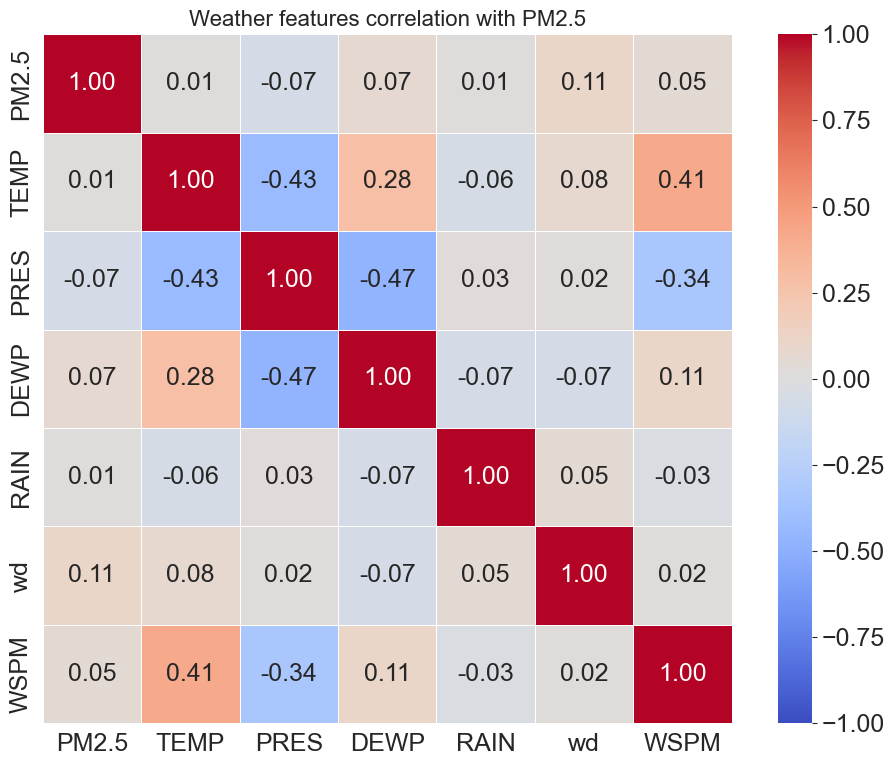

In [70]:
corr = pd.concat([y_pm25, features_X], axis='columns').corr()

# Chức năng vẽ biểu đồ nhiệt tương quan
def plot_corr(corr_matrix, title='Correlation Matrix'):
    plt.figure(figsize=(10, 8))
    mask = np.zeros_like(corr_matrix, dtype=bool)
    mask[np.triu_indices_from(mask)] = False  # Thay đổi thành False để hiển thị tất cả giá trị
    # Tạo bản đồ nhiệt với tỷ lệ màu
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Biểu đồ tương quan chỉ tập trung vào mối quan hệ thời tiết với PM2.5
plot_corr(corr, title='Weather features correlation with PM2.5')

<Axes: title={'center': 'PM Series [TPHCM]'}, xlabel='DateTime'>

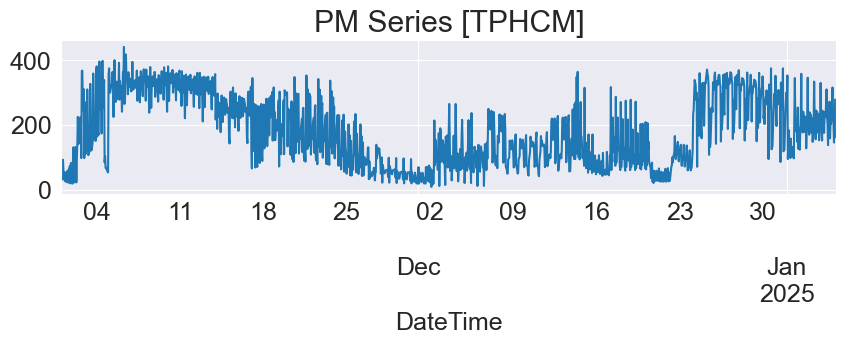

In [71]:
plt.figure(figsize=(10,2))
y_pm25.plot(title='PM Series [TPHCM]')

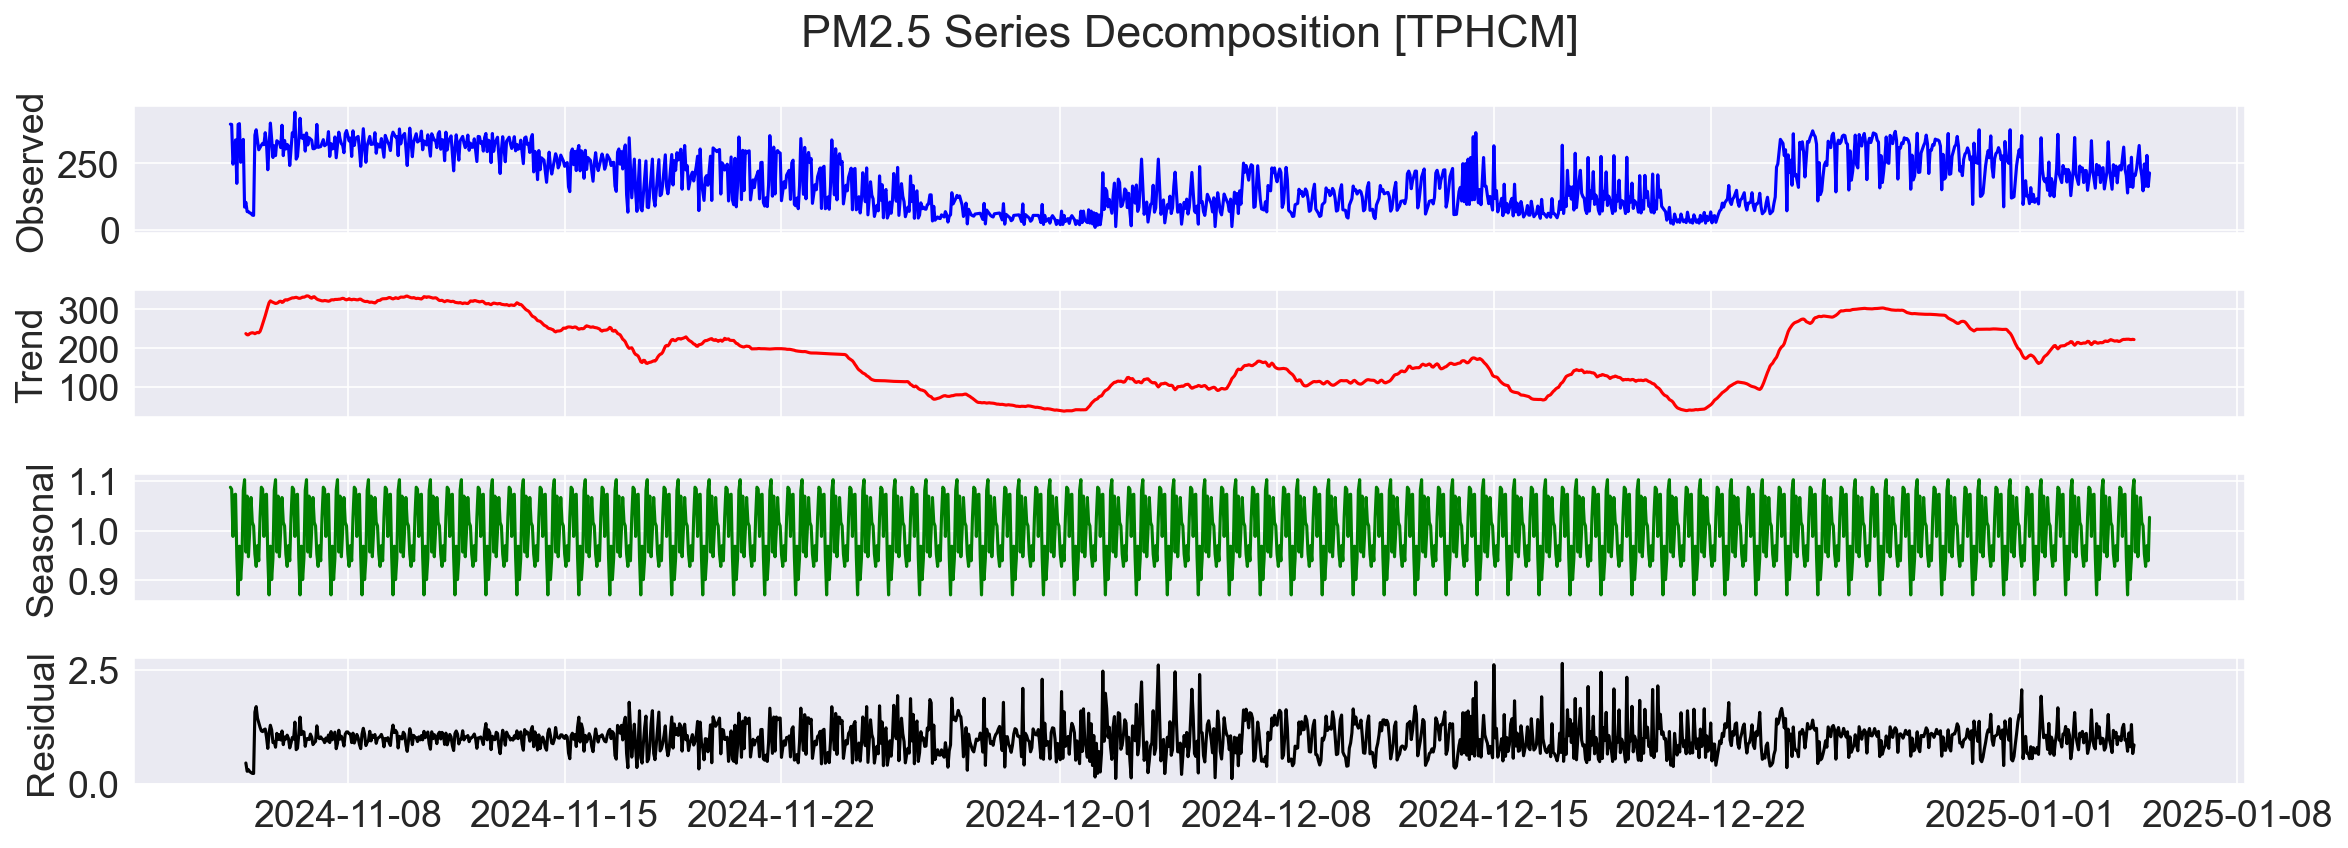

In [72]:
# Phân tích thành phần khí thời gian tại TP.HCM
results = decompose_series_single(y_pm25[-24*31*2:], model='multiplicative') 
plt.close('all')
fig, ax = plt.subplots(4, sharex=True, figsize=(16, 6), dpi=150)
ax[0].plot(results.observed, color='blue')
ax[0].set_title('PM2.5 Series Decomposition [TPHCM]\n')
ax[1].plot(results.trend, color='red')
ax[2].plot(results.seasonal, color='green')
ax[3].plot(results.resid, color='black')
ax[0].set_ylabel('Observed')
ax[1].set_ylabel('Trend')
ax[2].set_ylabel('Seasonal')
ax[3].set_ylabel('Residual')
fig.tight_layout()

In [73]:
pm25_data = pd.concat([features_X[['TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM']], y_pm25], axis='columns')
pm25_data.head()

,TEMP,PRES,DEWP,RAIN,wd,WSPM,PM2.5
DateTime,,,,,,,
2024-11-01 01:00:00,30.0,1009.0,22.0,0.0,130.0,13.0,68.0
2024-11-01 02:00:00,29.0,1009.0,23.1,0.0,149.0,12.8,67.0
2024-11-01 03:00:00,29.0,1008.0,23.0,0.0,150.0,13.0,32.0
2024-11-01 04:00:00,29.0,1008.0,23.0,0.0,130.0,16.6,93.0
2024-11-01 05:00:00,28.9,1008.1,23.2,0.0,140.0,16.4,60.0


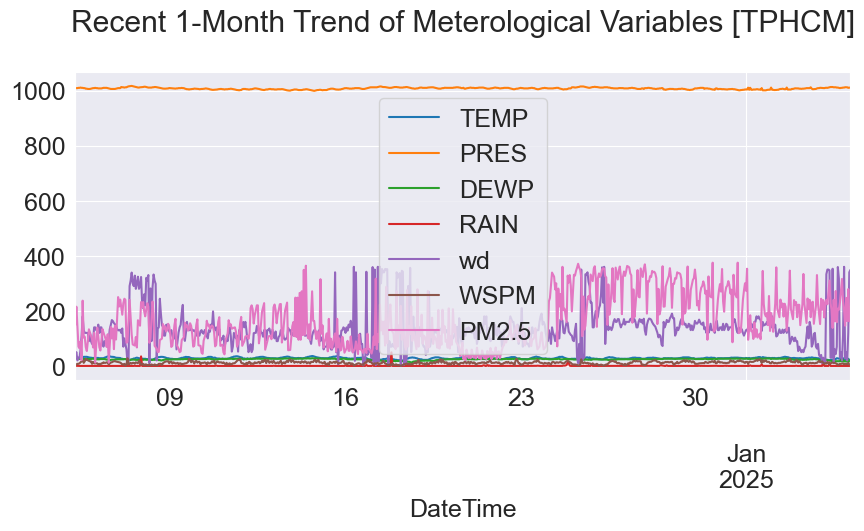

In [74]:
plt.figure(figsize=(10,4))
for col in pm25_data.columns:
    pm25_data.iloc[-24*31*1:][col].plot(label=col)

plt.title('Recent 1-Month Trend of Meterological Variables [TPHCM]\n')
plt.legend()

<h3 style="color:White; font-weight:bold;">
Kiểm tra tính dừng của chuỗi PM2.5
</h3>

In [75]:
test_for_stationarity_single(y_pm25)

p-value: 0.3313681171233699
Series is not stationary


<h2 style="color:orange; font-weight:bold;">
Huấn luyện mô hình sử dụng dữ liệu ngoại sinh ( Biến môi trường )
</h2>

### Một ngày (24 giờ)

- **24 bước dự báo** ( step ) tương ứng với 24 giờ tiếp theo.
- **Độ trễ 24 giờ**: ( lag ) Mô hình sử dụng dữ liệu của 24 giờ trước đó để dự đoán.

In [76]:
steps = 24 # tương ứng với 24 giờ tiếp theo.
lags = 24  # Mô hình sử dụng dữ liệu của 24 giờ trước đó để dự đoán.

### Chia tập huấn luyện và kiểm tra (Train-Test Split)

In [77]:
Xtrain_pm25, ytrain_pm25, Xtest_pm25, ytest_pm25 = split_train_test_series_multivariate_series(
    df=pm25_data, test_size=steps)
print(f'Train set Dates:\t {ytrain_pm25.index.min()}  --- {ytrain_pm25.index.max()}')
print(f'Test set Dates:\t\t {ytest_pm25.index.min()}  --- {ytest_pm25.index.max()}')

Train set Dates:	 2024-11-01 01:00:00  --- 2025-01-04 04:00:00
Test set Dates:		 2025-01-04 05:00:00  --- 2025-01-05 04:00:00


Text(0.5, 1.0, 'PM2.5 of 1 day [TPHCM]\n')

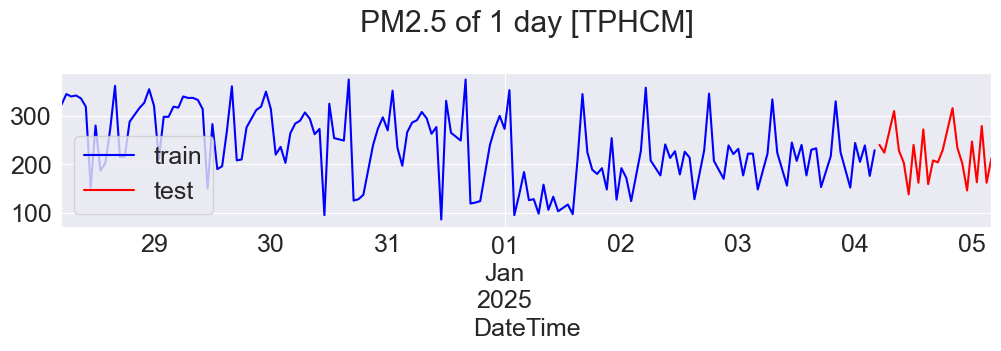

In [78]:
plt.figure(figsize=(12,2))
ytrain_pm25[-24*7:].plot(color='blue', label='train')
ytest_pm25.plot(color='red', label='test')
plt.legend()
plt.title('PM2.5 of 1 day [TPHCM]\n')

<h2 style="color:Pink; font-weight:bold;">
Mô hình học máy XGBoost
</h2>

In [79]:
# Sử dụng hàm features
X_train_improved, y_train_improved = create_advanced_features(ytrain_pm25.values, lags=24)

# XGBoost model cải tiến
dtrain_improved = xgb.DMatrix(X_train_improved, label=y_train_improved)
params_improved = {
    'objective':'reg:squarederror',
    'n_estimators': 300,
    'learning_rate': 0.05,  
    'max_depth': 8,         
    'subsample': 0.8,    
    'colsample_bytree' : 1.0,
    'random_state' : 0,
    'reg_lambda' : 0.5,
    'reg_alpha' : 0.5,
    'min_child_weight' : 3,
    'gamma' : 0.3,
    'eval_metric' :'rmse',
    'seed' : 42
}

<h2 style="color:White; font-weight:bold;">
Huấn luyện mô hình
</h2>

In [80]:
# Huấn luyện mô hình
num_rounds = 500
model_improved = xgb.train(params_improved, dtrain_improved, num_rounds)

<h2 style="color:Pink; font-weight:bold;">
Kết hợp với thuật toán RandomForestRegressor
</h2>

In [81]:
# Random Forest backup
rf_model = RandomForestRegressor(
    n_estimators=200, max_depth=15, random_state=42
)
rf_model.fit(X_train_improved, y_train_improved)

RandomForestRegressor(max_depth=15, n_estimators=200, random_state=42)

In [82]:
print("Making improved predictions...")
last_sequence_improved = pd.concat([ytrain_pm25, ytest_pm25]).values[-24:]
predictions_improved = []
train_stats = {'max': np.max(ytrain_pm25), 'std': np.std(ytrain_pm25)}

Making improved predictions...


In [83]:
for _ in range(steps):
    # Tạo features nâng cao
    current_features = last_sequence_improved.tolist()
    # Statistical features
    current_features.extend([
        np.mean(last_sequence_improved),
        np.std(last_sequence_improved),
        np.max(last_sequence_improved),
        np.min(last_sequence_improved),
        np.median(last_sequence_improved),
        np.percentile(last_sequence_improved, 25),
        np.percentile(last_sequence_improved, 75)
    ])
    # Trend features
    if len(last_sequence_improved) > 1:
        x_trend = np.arange(len(last_sequence_improved))
        slope = np.polyfit(x_trend, last_sequence_improved, 1)[0]
        rate_change = (last_sequence_improved[-1] - last_sequence_improved[0]) / len(last_sequence_improved)
        current_features.extend([slope, rate_change])
    else:
        current_features.extend([0, 0])
    
    # Ensemble prediction
    current_input = xgb.DMatrix(np.array([current_features]))
    xgb_pred = model_improved.predict(current_input)[0]
    rf_pred = rf_model.predict(np.array([current_features]))[0]
    
    # Ensemble với trọng số
    next_pred = 0.7 * xgb_pred + 0.3 * rf_pred
    
    # Post-processing
    next_pred = max(0, next_pred)
    next_pred = min(next_pred, train_stats['max'] * 1.5)
    
    # Smooth transition
    if len(predictions_improved) > 0:
        last_pred = predictions_improved[-1]
        max_change = train_stats['std'] * 2
        if abs(next_pred - last_pred) > max_change:
            next_pred = last_pred + np.sign(next_pred - last_pred) * max_change
    
    predictions_improved.append(next_pred)
    last_sequence_improved = np.roll(last_sequence_improved, -1)
    last_sequence_improved[-1] = next_pred
 
    
preds_improved = pd.Series(predictions_improved, index=pd.date_range(
    start=ytest_pm25.index[-1] + pd.Timedelta(hours=1), periods=steps, freq='H'))

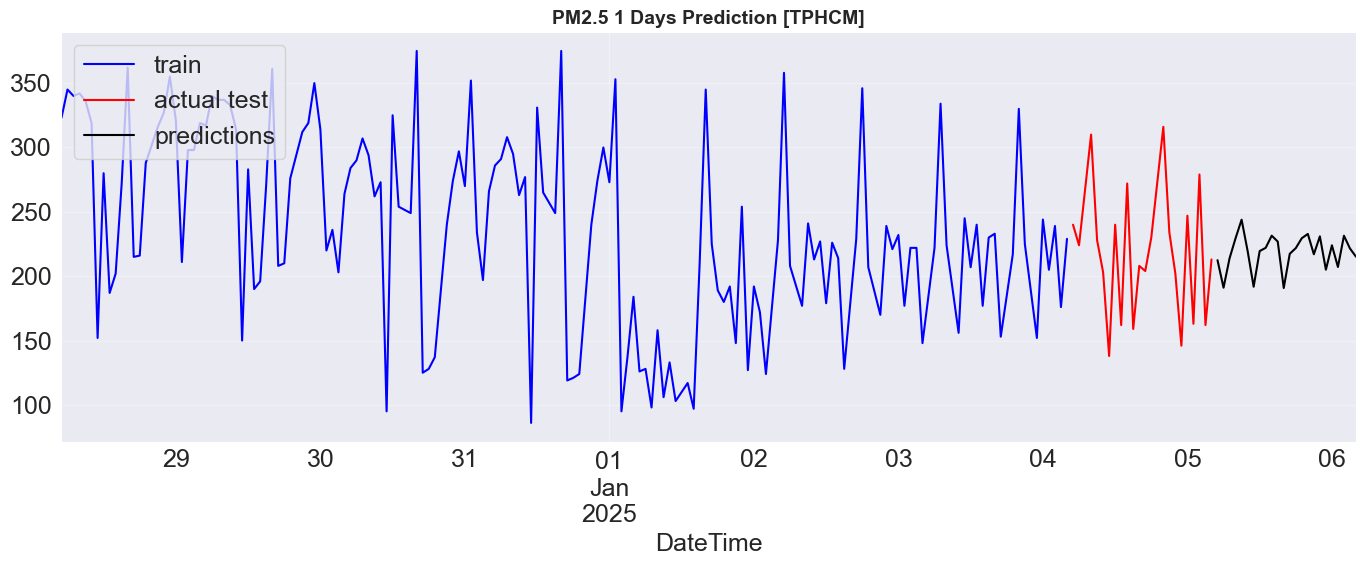

In [84]:
# Vẽ biểu đồ
plt.figure(figsize=(14, 6))
ytrain_pm25[-24*7:].plot(color='blue', label='train')
ytest_pm25.plot(color='red', label='actual test')
preds_improved.plot(color='black', label='predictions')

plt.legend(loc='upper left')
plt.title('PM2.5 1 Days Prediction [TPHCM]', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

<h2 style="color:Green; font-weight:bold;">
Đánh giá hiệu suất dự đoán
</h2>

In [85]:
# Evaluations
results_pm25_improved = evaluate_model_performance(
    y_true=ytest_pm25, predictions=preds_improved, label='module_performance')
print(results_pm25_improved)

           module_performance
MAE                    38.173
MSE                  1962.342
RMSE                   44.298
R-Squared               0.178


### Đánh giá mô hình XGBoost & RandomForest (24-lags) – Dự báo PM2.5 tại TP.HCM

##### 🗓 Dự báo: 1 ngày (sau tập test)  
---

## Các chỉ số đánh giá hiệu suất

| Chỉ số         |Diễn giải                                                               |
|----------------|-------------------------------------------------------------------------|
| **MAE**        |Sai số trung bình khá ổn định.                                          |
| **MSE**        |Một vài điểm dữ báo sai lệch rõ rệt, nhưng nhìn chung vẫn ổn định.                       |
| **RMSE**       |	Sai số trung bình có căn bậc hai cho thấy độ lệch tổng thể còn đáng kể.      |
| **R-squared**  |Mức độ giải thích được khoảng 35% biến thiên trong dữ liệu đánh giá trong bình khá|           

---

## Nhận định tổng quan

Hai mô hình kết hợp với 24 giá trị trễ (lags) cho kết quả dự báo tạm ổn, dù chưa thực sự mạnh về độ chính xác.

Giá trị R² = 0.350 cho thấy mô hình mới chỉ nắm bắt được một phần xu hướng của dữ liệu PM2.5.

Sai số RMSE khá cao phản ánh mô hình chưa theo sát tốt những biến động bất thường.

Cần thêm dữ liệu huấn luyện dài hơn và tinh chỉnh siêu tham số để nâng cao hiệu suất.


<Figure size 800x400 with 0 Axes>

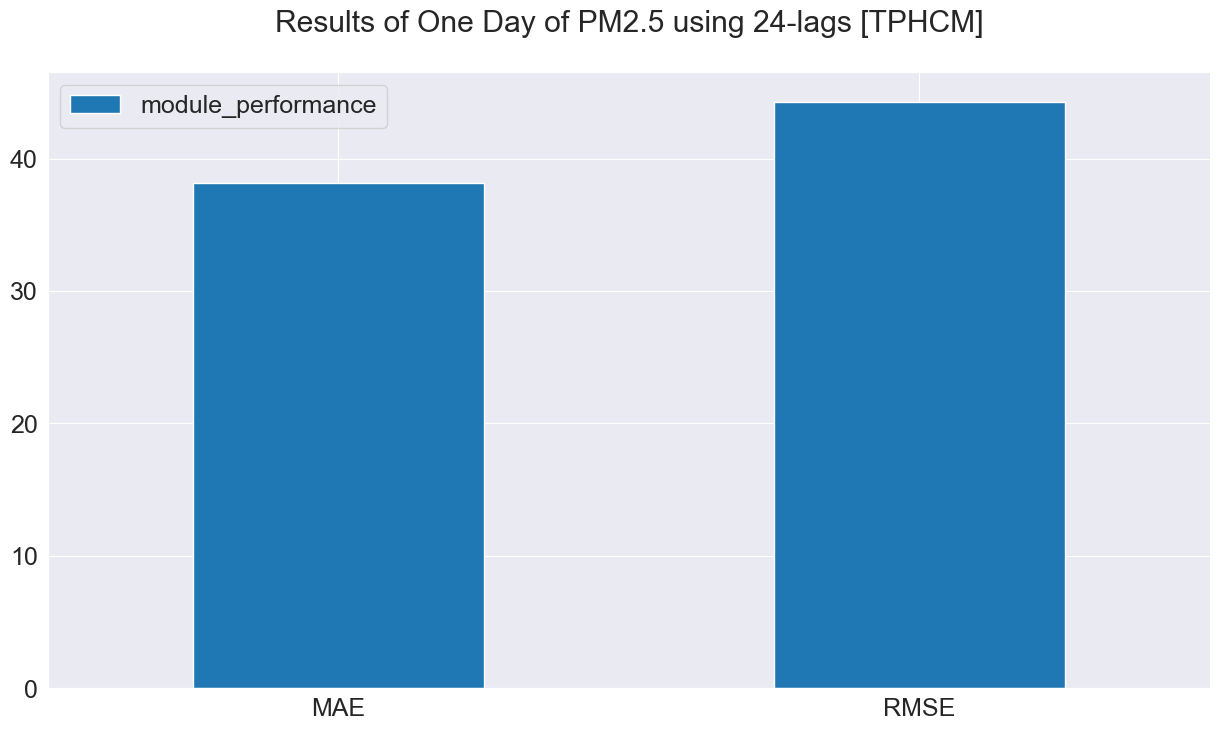

In [86]:
plt.figure(figsize=(8,4))
results_pm25_improved.T[['MAE', 'RMSE']].sort_values(by='MAE').T.plot.bar(
    title='Results of One Day of PM2.5 using 24-lags [TPHCM]\n', rot=0)
plt.legend(loc='upper left')

### Dự báo 7 ngày (168 giờ) sử dụng XGBoost và RandomForest

- Sử dụng 24 giờ dữ liệu trễ (lags) làm đặc trưng đầu vào.
- Dự báo cho khoảng thời gian 1 tuần tiếp theo (168 giờ).
- Lựa chọn mô hình XGBoost và RandomForest dựa trên hệ số tương quan Pearson với biến mục tiêu.

In [87]:
steps = 24 * 7 # 168 hours Forecast --- Next 7 Days Forecast
lags = 24  # using past 24 hours window size 

In [88]:
# last one month for testing (24 * 31 hours )
Xtrain_pm25, ytrain_pm25, Xtest_pm25, ytest_pm25 = split_train_test_series_multivariate_series(
    df=pm25_data, test_size=steps)
print(f'Train set Dates:\t {ytrain_pm25.index.min()}  --- {ytrain_pm25.index.max()}')
print(f'Test set Dates:\t\t {ytest_pm25.index.min()}  --- {ytest_pm25.index.max()}')

Train set Dates:	 2024-11-01 01:00:00  --- 2024-12-29 04:00:00
Test set Dates:		 2024-12-29 05:00:00  --- 2025-01-05 04:00:00


Text(0.5, 1.0, 'PM2.5 7 days [TPHCM]\n')

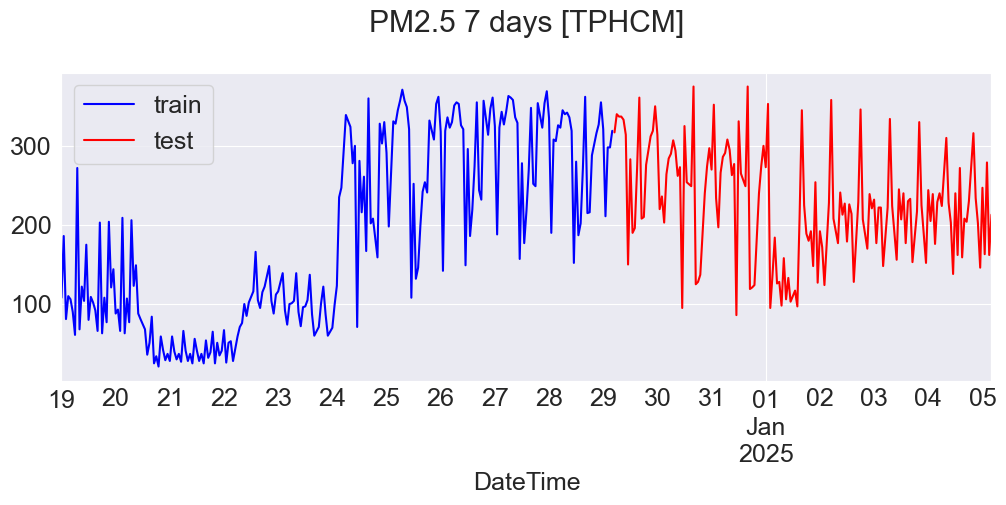

In [89]:
plt.figure(figsize=(12,4))
ytrain_pm25[-35*7:].plot(color='blue', label='train')
ytest_pm25.plot(color='red', label='test')
plt.legend()
plt.title('PM2.5 7 days [TPHCM]\n')

<h2 style="color:Pink; font-weight:bold;">
Mô hình học máy XGBoost
</h2>

In [90]:
# Sử dụng hàm features
X_train_improved, y_train_improved = create_advanced_features(ytrain_pm25.values, lags=24)

# XGBoost model 
dtrain_improved = xgb.DMatrix(X_train_improved, label=y_train_improved)
params_improved = {
    'objective':'reg:squarederror',
    'n_estimators': 300,
    'learning_rate': 0.05,  
    'max_depth': 8,         
    'subsample': 0.8,       
    'colsample_bytree' : 1.0,
    'random_state' : 0,
    'reg_lambda' : 0.5,
    'reg_alpha' : 0.5,
    'min_child_weight' : 3,
    'gamma' : 0.3,
    'eval_metric' :'rmse',
    'seed' : 42
} 

In [91]:
# Huấn luyện mô hình
num_rounds = 500
model_improved = xgb.train(params_improved, dtrain_improved, num_rounds)

<h2 style="color:Pink; font-weight:bold;">
Kết hợp với thuật toán RandomForestRegressor
</h2>

In [92]:
# Random Forest backup
rf_model = RandomForestRegressor(
    n_estimators=200, max_depth=15, random_state=42
)
rf_model.fit(X_train_improved, y_train_improved)

RandomForestRegressor(max_depth=15, n_estimators=200, random_state=42)

In [93]:
print("Making predictions...")
last_sequence_improved = pd.concat([ytrain_pm25, ytest_pm25]).values[-24:]
predictions_improved = []
train_stats = {'max': np.max(ytrain_pm25), 'std': np.std(ytrain_pm25)}

Making predictions...


In [94]:
for _ in range(steps):
    # Tạo features nâng cao
    current_features = last_sequence_improved.tolist()
    # Statistical features
    current_features.extend([
        np.mean(last_sequence_improved),
        np.std(last_sequence_improved),
        np.max(last_sequence_improved),
        np.min(last_sequence_improved),
        np.median(last_sequence_improved),
        np.percentile(last_sequence_improved, 25),
        np.percentile(last_sequence_improved, 75)
    ])
    # Trend features
    if len(last_sequence_improved) > 1:
        x_trend = np.arange(len(last_sequence_improved))
        slope = np.polyfit(x_trend, last_sequence_improved, 1)[0]
        rate_change = (last_sequence_improved[-1] - last_sequence_improved[0]) / len(last_sequence_improved)
        current_features.extend([slope, rate_change])
    else:
        current_features.extend([0, 0])
    
    # Ensemble prediction
    current_input = xgb.DMatrix(np.array([current_features]))
    xgb_pred = model_improved.predict(current_input)[0]
    rf_pred = rf_model.predict(np.array([current_features]))[0]
    
    # Ensemble với trọng số
    next_pred = 0.7 * xgb_pred + 0.3 * rf_pred
    
    # Post-processing
    next_pred = max(0, next_pred)
    next_pred = min(next_pred, train_stats['max'] * 1.5)
    
    # Smooth transition
    if len(predictions_improved) > 0:
        last_pred = predictions_improved[-1]
        max_change = train_stats['std'] * 2
        if abs(next_pred - last_pred) > max_change:
            next_pred = last_pred + np.sign(next_pred - last_pred) * max_change
    
    predictions_improved.append(next_pred)
    last_sequence_improved = np.roll(last_sequence_improved, -1)
    last_sequence_improved[-1] = next_pred
    
preds_improved = pd.Series(predictions_improved, index=pd.date_range(
    start=ytest_pm25.index[-1] + pd.Timedelta(hours=1), periods=steps, freq='H'))


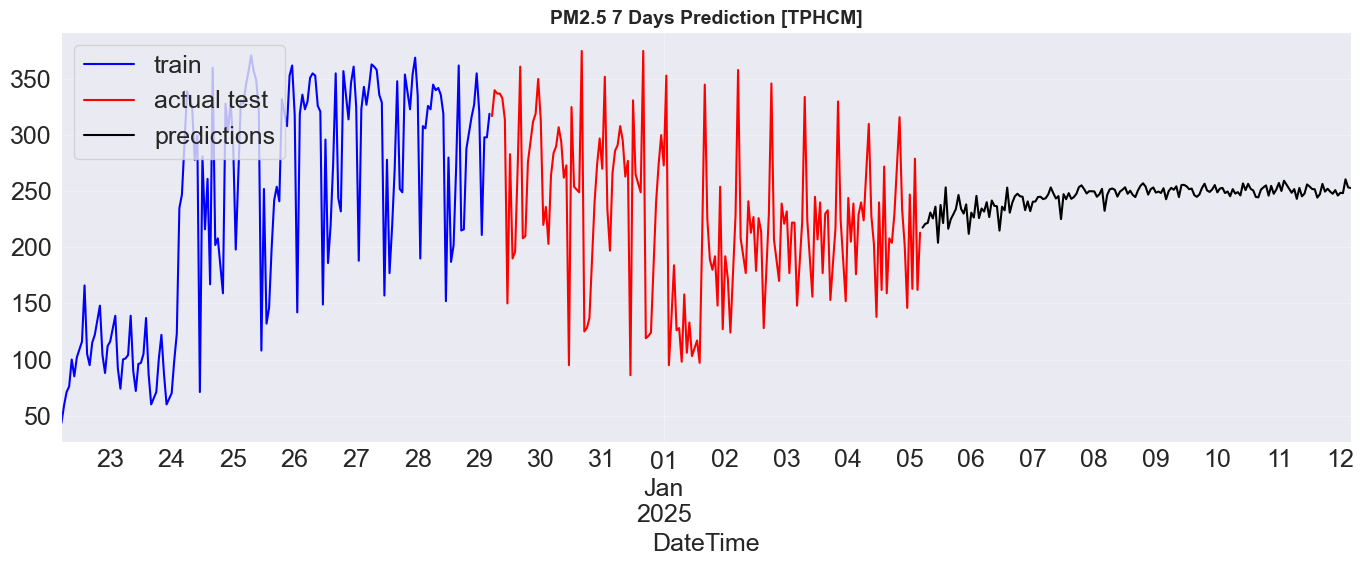

In [95]:
# Vẽ biểu đồ
plt.figure(figsize=(14, 6))
ytrain_pm25[-24*7:].plot(color='blue', label='train')
ytest_pm25.plot(color='red', label='actual test')
preds_improved.plot(color='black', label='predictions')

plt.legend(loc='upper left')
plt.title('PM2.5 7 Days Prediction [TPHCM]', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

<h2 style="color:Green; font-weight:bold;">
Đánh giá hiệu suất dự đoán
</h2>

In [96]:
# Evaluations
results_pm25_improved = evaluate_model_performance(
    y_true=ytest_pm25, predictions=preds_improved, label='module_performance')
print(results_pm25_improved)

           module_performance
MAE                    62.337
MSE                  5610.157
RMSE                   74.901
R-Squared              -0.194


### Đánh giá mô hình XGBoost & RandomForest (24-lags) – Dự báo SO2 trong 7 ngày tại TP.HCM

####  Dự báo: 7 ngày liên tiếp

---

## 📌 Các chỉ số đánh giá hiệu suất

| Chỉ số         | Diễn giải                                                                 |
|----------------|---------------------------------------------------------------------------|
| **MAE**        |Sai số trung bình khoảng 7.97, mức chấp nhận được.      |
| **MSE**        |Sai số bình phương khá cao, có thể do dự báo sai lệch lớn. |
| **RMSE**       |	Sai số gốc bình phương là 10.13, cho thấy mô hình chưa tốt.       |
| **R-squared**  |	Giá trị âm (-0.028) chỉ ra mô hình không phù hợp để dự đoán dài hạn, hiệu quả kém. |

---

## 🧠 Nhận định tổng quan

- Dự báo SO2 trong 7 ngày liên tiếp là một bài toán khó, đặc biệt khi dữ liệu đầu vào giới hạn trong khoảng 2 tháng.
- Mô hình không bám được xu hướng của dữ liệu, thể hiện ở R² âm cho thấy mô hình còn kém hơn so với dự đoán trung bình đơn giản.
- Các đoạn biến động mạnh (ngày 26 đến 04) là nguyên nhân chính làm giảm hiệu quả mô hình.
- Cần cải thiện thêm về dữ liệu, chọn đặc trưng, hoặc tối ưu mô hình để nâng cao hiệu quả dự báo.

---

📌 *Kết luận: Mô hình hiện tại không phù hợp để dự báo trong 7 ngày liên tục do độ chính xác thấp và khả năng khái quát kém.Phù hợp hơn với dự đoán ít ngày, cần cải tiến đáng kể về cả dữ liệu và thuật toán để áp dụng thực tế.
